This notebook lays out the model training process for ConvLSTM, including loading the data, hyperparameter setting, and customizing the loss function.

The ConvLSTM implementation is from [GeoTorchAI](https://kanchanchy.github.io/geotorchai/index.html) for experimentation. The code for training the ConvLSTM is adapted from [here](https://kanchanchy.github.io/geotorchai/coding_examples.html). See [here](https://kanchanchy.github.io/geotorchai/installation.html) for instructions on how to install GeoTorchAI.

Refer to `scripts/run.py` for the streamlined code.

In [30]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from geotorchai.models.grid import ConvLSTM

import matplotlib.pyplot as plt

# autoreload modules when code is changed
%load_ext autoreload
%autoreload 2

# load ImageFolder.py from scripts folder
import sys
sys.path.append('../scripts/')
from image_folder import ImageFolder, ImageDataset
from loss_functions import SSIMLoss, PhaseFieldLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize device with GPU
In order to perform deep learning with GPU, we need to check whether GPU is available at first. We will initialize the device with GPU if it is available. Otherwise, CPU will be used as the default device.

In [8]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(device)

mps


## Define method for calculating three types of errors: MSE, MAE, RMSE

In [9]:
def compute_errors(preds, y_true):
    pred_mean = preds[:, 0:2]
    diff = y_true - pred_mean

    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(diff))

    return mse, mae, rmse             

## Define method for calculating validation loss

In [10]:
def get_validation_loss(model, val_generator, criterion, device, len_history):
    model.eval()
    mean_loss = []
    for i, sample in enumerate(val_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        # might need to set this to just outputs if we are using just mseLoss
        loss=criterion(outputs[:, len_history - 1:len_history, :, :, :], Y_batch).item()
        mean_loss.append(loss)

    mean_loss = np.mean(mean_loss)
    return mean_loss

## Define model class

In [11]:
class GeoTorchConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers):
        super().__init__()
        self.lstm = ConvLSTM(input_dim=input_size, 
                             hidden_dim=hidden_dim, 
                             num_layers=num_layers)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        return lstm_out

## Initialize parameters

In [13]:
# model parameters
input_dim = 1
input_width = 128
input_height = 128
hidden_layer_sizes = [256, 256, 1]
num_layers = len(hidden_layer_sizes)

# sequence lengths
len_history = 5
len_predict = 1

# training parameters
epoch_nums = 40
learning_rate = 0.002
batch_size = 4
params = {'batch_size': batch_size, 'shuffle': False, 'drop_last':False, 'num_workers': 2}

# Create function that assigns model name to global variable
def set_model_name(name):
    global model_name, model_dir, initial_checkpoint
    model_name = name

    # Sets the model output directory
    checkpoint_dir = '../models'
    model_name = name
    model_dir = checkpoint_dir + "/" + model_name
    model_dir_plots = model_dir + "/plots"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(model_dir_plots, exist_ok=True)

    # For loading pretrained model if available
    initial_checkpoint = model_dir + '/model.best.pth'


## Load Data

In [14]:
# Set data paths
data_root = '../data/cracks_s_nb'
train_path = os.path.join(data_root, "train")
test_path = os.path.join(data_root, "test")
val_path = os.path.join(data_root, "val")

In [15]:
train = ImageFolder(root=train_path, transform=transforms.ToTensor())
test = ImageFolder(root=test_path, transform=transforms.ToTensor())
val = ImageFolder(root=val_path, transform=transforms.ToTensor())

train.set_sequential_representation(history_length=len_history, predict_length=len_predict)
test.set_sequential_representation(history_length=len_history, predict_length=len_predict)
val.set_sequential_representation(history_length=len_history, predict_length=len_predict)

train_generator = DataLoader(ImageDataset(train), **params)
test_generator = DataLoader(ImageDataset(test), **params)
val_generator = DataLoader(ImageDataset(val), **params)

In [16]:
train.__getitem__(0).shape

torch.Size([1, 128, 128])

## Define method for initializing model and perform training and testing

In [17]:
# Write a function to use plt to save the model predictions
def save_pred_plots(outputs, Y_batch, epoch, num_samples=batch_size):
    for i in range(num_samples):
        try:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(outputs[i, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
            plt.axis('off')
            plt.title("Predicted")
            plt.subplot(1, 2, 2)
            plt.imshow(np.squeeze(Y_batch[i, 0, :, :].cpu().data.numpy()), cmap='gray')
            plt.axis('off')
            plt.title("Ground Truth")

            # save figure to model_dir
            plt.savefig(model_dir + f"/sample_{i}_{epoch}.png")
        except:
            print(f"sample {i} failed to plot")
            continue

In [18]:
def createModelAndTrain(loss_fn, LOAD_INITIAL=False):
    device = get_device()

    model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)

    if LOAD_INITIAL:
        model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))

    # calculate step size for saving prediction plots
    step_size = epoch_nums // 10

    loss_fn = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    loss_fn.to(device)

    min_val_loss = None
    for e in range(epoch_nums):
        for i, sample in enumerate(train_generator):
            X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
            Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = loss_fn(outputs[:, len_history - 1:len_history, :, :, :], Y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = get_validation_loss(model, val_generator, loss_fn, device, len_history)
        
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(e + 1, epoch_nums, loss.item()), 'Mean Val Loss:', val_loss)

        if min_val_loss == None or val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), initial_checkpoint)
            print('best model saved!')

    model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        mse, mae, rmse = compute_errors(outputs[:, len_history - 1:len_history, :, :, :].cpu().data.numpy(),
                                        Y_batch.cpu().data.numpy())

        rmse_list.append(rmse)
        mse_list.append(mse)
        mae_list.append(mae)

        if (e + 1) % step_size == 0:
            # save outputs to plot later
            save_pred_plots(outputs, Y_batch, epoch=e+1, num_samples=batch_size)

    rmse = np.mean(rmse_list)
    mse = np.mean(mse_list)
    mae = np.mean(mae_list)

    print("\n************************")
    print("Test ConvLSTM model with Crack Dataset:")
    print('Test mse: %.6f mae: %.6f rmse (norm): %.6f' % (
    mse, mae, rmse))

## Define loss functions

In [19]:
# Set loss functions
loss_mse = nn.MSELoss()
loss_ssim = SSIMLoss()
loss_phasefield = PhaseFieldLoss()

## Call model training and testing from main

In [ ]:
if __name__ == '__main__':
    try:
        epoch_nums = 10
        learning_rate = 0.002
        loss = 'mse'
        set_model_name(f'convlstm_{loss}_epoch{epoch_nums}_lr{learning_rate}')
        createModelAndTrain(loss_fn=loss_mse)
        # createModelAndTrain(loss_fn=loss_ssim)
        # createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

In [75]:
if __name__ == '__main__':
    try:
        # createModelAndTrain(loss_fn=loss_mse)
        createModelAndTrain(loss_fn=loss_ssim)
        # createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

Epoch [1/10], Train Loss: 0.1037 Mean Val Loss: 0.14431150601460382
best model saved!
Epoch [2/10], Train Loss: 0.0222 Mean Val Loss: 0.037553525888002835
best model saved!
Epoch [3/10], Train Loss: 0.0193 Mean Val Loss: 0.028664781497075006
best model saved!
Epoch [4/10], Train Loss: 0.0185 Mean Val Loss: 0.027186833895169772
best model saved!
Epoch [5/10], Train Loss: 0.0185 Mean Val Loss: 0.026281187167534463
best model saved!
Epoch [6/10], Train Loss: 0.0186 Mean Val Loss: 0.02626206324650691
best model saved!
Epoch [7/10], Train Loss: 0.0184 Mean Val Loss: 0.025435915360083945
best model saved!
Epoch [8/10], Train Loss: 0.0174 Mean Val Loss: 0.02528937504841731
best model saved!
Epoch [9/10], Train Loss: 0.0164 Mean Val Loss: 0.024914920330047607
best model saved!
Epoch [10/10], Train Loss: 0.0164 Mean Val Loss: 0.024544459122877855
best model saved!

************************
Test ConvLSTM model with Crack Dataset:
Test mse: 0.000307 mae: 0.002647 rmse (norm): 0.016895


In [76]:
if __name__ == '__main__':
    try:
        # createModelAndTrain(loss_fn=loss_mse)
        # createModelAndTrain(loss_fn=loss_ssim)
        createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Shape: torch.Size([4, 0, 0, 128, 128])
Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Shape: torch.Size([4, 0, 0, 128, 128])
Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Shape: torch.Size([4, 0, 0, 128, 128])
Predicted Image Shape: torch.Size([4, 1, 1, 128, 128])
Ground Truth Shape: torch.Size([4, 1, 1, 128, 128])
Grad Phi X Shape: torch.Size([4, 1, 0, 128, 128])
Grad Phi Y Shape: torch.Size([4, 0, 1, 128, 128])
PDE Residual Sha

KeyboardInterrupt: 

# Visualize Predictions

In [28]:
# Load model from checkpoint file in models folder
model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)
model.load_state_dict(torch.load(initial_checkpoint))
model.to(device)

GeoTorchConvLSTM(
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): _ConvLSTMCell(
        (conv): Conv2d(257, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (1): _ConvLSTMCell(
        (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (2): _ConvLSTMCell(
        (conv): Conv2d(257, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
  )
)

In [23]:
# Write a function to use plt to show the model predictions
def show_predictions(model, test_generator, device, num_samples=5):
    model.eval()
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)

        # TO-DO: fix the code here in case num_samples > batch_size
        for j in range(num_samples):
            try:
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(outputs[j, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
                plt.axis('off')
                plt.title("Predicted")
                plt.subplot(1, 2, 2)
                plt.imshow(np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy()), cmap='gray')
                plt.axis('off')
                plt.title("Ground Truth")
                plt.show()
            except:
                print(f"sample {j} failed to plot")
                continue

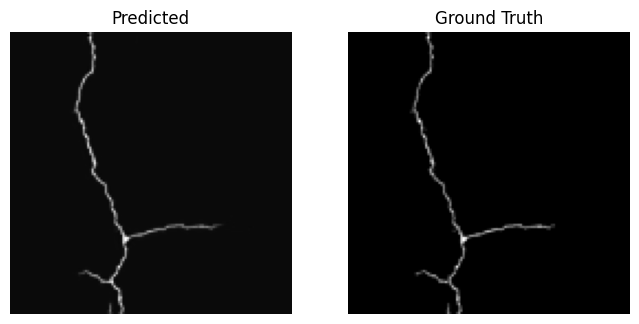

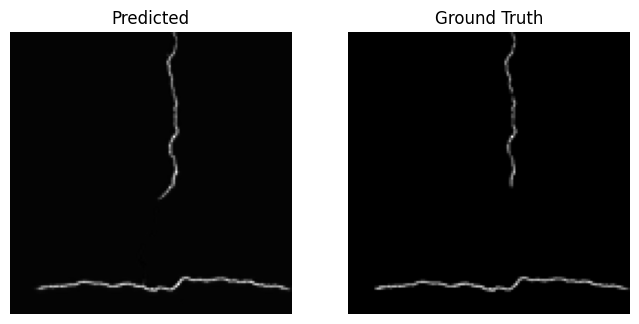

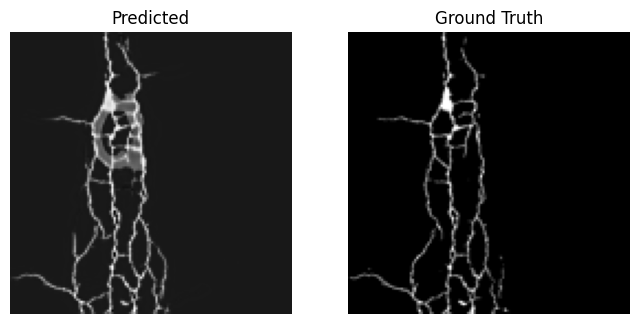

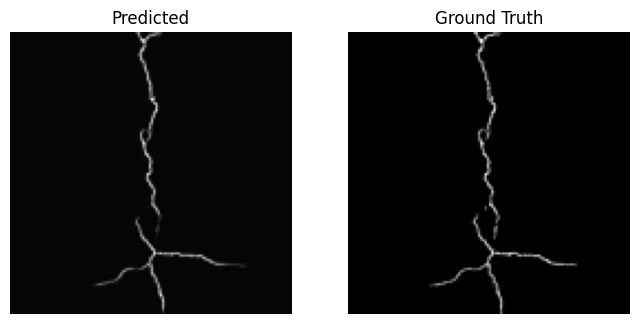

sample 4 failed to plot
sample 5 failed to plot
sample 6 failed to plot
sample 7 failed to plot
sample 8 failed to plot
sample 9 failed to plot


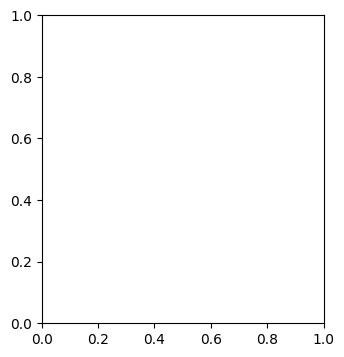

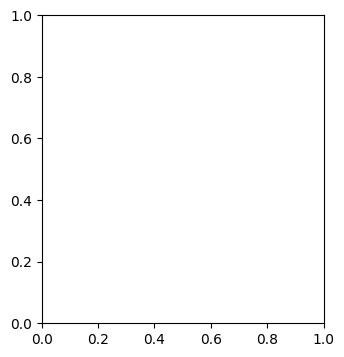

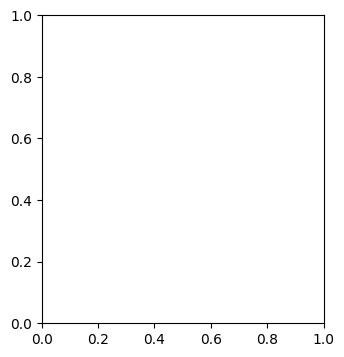

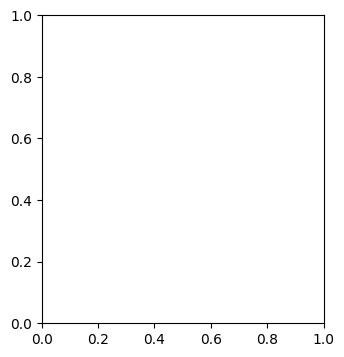

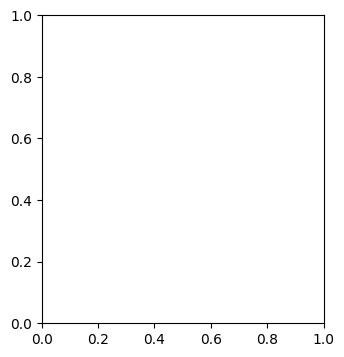

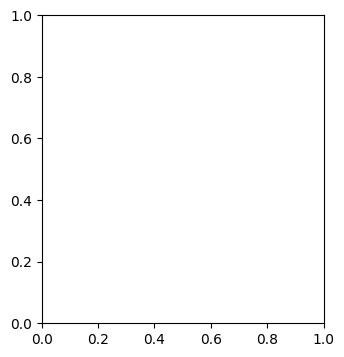

In [78]:
show_predictions(model, test_generator, device, num_samples=10)